In [ ]:
#| hide
#| default_exp simple_gp_imputation

# Simple GP Imputation

> Imputation using a different Gaussian Processes for each variable

In [ ]:
#| hide
#| export
from gpfa_imputation.data_preparation import *
from gpfa_imputation.learner import NormParam
from gpfa_imputation.results import GPFAResult

from fastcore.foundation import patch 
import gpytorch
import torch
from torch import Tensor
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## GP

In [ ]:
#| export
class SimpleGP(gpytorch.models.ExactGP):
    "Exact GP implemnetation using GPyTorch"
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x, **params):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x, **params)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
k = SimpleGP(torch.tensor([1,2,3]), torch.tensor([1,2,3]), gpytorch.likelihoods.GaussianLikelihood())

In [ ]:
k

SimpleGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [ ]:
k.covar_module.base_kernel.lengthscale.item()

0.6931471824645996

In [ ]:
k.covar_module.outputscale.item()

0.6931471824645996

In [ ]:
#| export
@patch
def get_info(self: SimpleGP,
             var_names = None # Optional variable names for better printing
            ) -> dict[str, pd.DataFrame]:
    "Model info for a GPFA with a RBFKernel"
    out = {}

    out["lengthscale"] = pd.DataFrame({'lengthscale': [self.covar_module.base_kernel.lengthscale.item()]})
    out["outputscale"] = pd.DataFrame({'outputscale': [self.covar_module.outputscale.item()]})
    out["likelihood"] = pd.DataFrame({'noise': [self.likelihood.noise_covar.noise.item()]})

    return out

In [ ]:
k.get_info()

{'lengthscale':    lengthscale
 0     0.693147,
 'outputscale':    outputscale
 0     0.693147,
 'likelihood':       noise
 0  0.693247}

## Learner

In [ ]:
#| export
class SimpleGPLearner():
    "Learner for a simple GP process. It handles only 1 dimensional time series"
    def __init__(self,
                 X: Tensor, # (n_obs) Univariate time series
                 T: Tensor = None, # (n_obs) Vector of time of observations.
                 # If none each observation are considered to be at the same distance
                ):
        self.prepare_X(X)
        if T is None: self.default_time(X)
        else: self.T = T
        self.T = self.T.to(X.device) # to support GPUs
        
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()
        self.model = SimpleGP(self.T, self.X, self.likelihood)
                
    def prepare_X(self, X):
        self.norm = Normalizer(X)
        self.X = self.norm.normalize(X)
        
    def default_time(self, X):
        self.T = torch.arange(X.shape[0])
        
    
    def train(self, n_iter=100, lr=0.1):
        # need to enable training mode
        self.model.train()
        self.likelihood.train()
        
        # Use the adam optimizer
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr) 
        
        # create new losses
        if not hasattr(self, 'losses'):
            self.losses = torch.zeros(n_iter)
            loss_offset = 0
        # append to previous losses
        else:
            loss_offset = self.losses.shape[0]
            self.losses = torch.concat([self.losses, torch.zeros(n_iter)])
            
        # "Loss" for GPs - the marginal log likelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self.model)
        for i in tqdm(range(n_iter)):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = self.model(self.T)
            # Calc loss and backprop gradients
            loss = -mll(output, self.X)
            self.losses[i + loss_offset] = loss.detach()
            loss.backward()
            self.printer(i)

            optimizer.step()
        
        
    def printer(self, i):
        pass
    
    @torch.no_grad() # don't calc gradients on predictions
    def predict_raw(self, T):
        self.model.eval()
        self.likelihood.eval()
        return self.likelihood(self.model(T))

    @torch.no_grad() # needed because raw output still has gradients attached
    def prediction_from_raw(self, raw_mean, raw_std):
        """ Takes a raw prediction and produces and final prediction, by reshaping and reversing normalization"""
        pred_mean = self.norm.reverse_normalize(raw_mean)
        pred_std = self.norm.reverse_normalize_std(raw_std)

        #remove pytorch gradients
        return NormParam(pred_mean.detach(), pred_std.detach())

    def predict(self, T):
        pred_raw = self.predict_raw(T)
        return self.prediction_from_raw(pred_raw.mean, pred_raw.stddev)

In [ ]:
X = torch.tensor([1.,2,3,4])

In [ ]:
l = SimpleGPLearner(X)

In [ ]:
l.train()

  0%|          | 0/100 [00:00<?, ?it/s]

/home/simone/anaconda3/envs/data-science/lib/python3.10/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


In [ ]:
l.predict(torch.tensor([5, 7]))

NormalParameters(mean=tensor([5.5955, 6.4173]), std=tensor([0.1980, 0.6468]))

Imputation

The imputation using simple GPs make a separate GP process for each variable, which are completely independent

In [ ]:
#| export
class SimpleGPImputationExplorer:
    def __init__(
        self,
        data: pd.DataFrame , #observed data with missing data as NA
        cuda = False, # Use GPU?
    ):
        self.data = data
        
        device = 'cuda' if cuda else 'cpu'
        
        self.T = torch.arange(0, len(data), dtype=torch.float32, device=device) # time is encoded with a increase of 1
        
        # Training data
        self.train_idx = ~self.data.isna().any(axis=1)
        self.train_data = torch.tensor(self.data[self.train_idx].to_numpy().astype(np.float32), device=device)
        self.train_T = self.T[self.train_idx]
        
        self.learners = []
        
        for i in range(self.data.shape[1]):
            self.make_var_learner(i)
        
                       
        # if cuda: self.learner.cuda()
        
    def make_var_learner(self, i):
        # get only the ith column from the data
        x = self.train_data[:,i]
        learner = SimpleGPLearner(x, self.train_T)
        self.learners.append(learner)

        
    def fit(self):
        "Fit learners to training data"
        
        for learner in self.learners:
            learner.train()
            
        return self

    def predict(self):
        
        # return always tidy df
        
        preds = []
        
        for learner, feature_name in zip(self.learners, self.data.columns):
            pred = learner.predict(self.T)
            pred_mean = pd.DataFrame(pred.mean.cpu(), columns = ["mean"]).assign(time = self.T.cpu())
            pred_std = pd.DataFrame(pred.std.cpu(), columns = ["std"]).assign(time = self.T.cpu())
            
            pred = pd.merge(pred_mean, pred_std, on='time').assign(variable = feature_name)
            preds.append(pred)
                    
        
        return pd.concat(preds)
    
    def fit_predict(self):
        self.fit()
        return self.predict()

    
    def __repr__(self):
        return f"""Simple GP Imputation Explorer:
    N obs: {self.data.shape[0]}
    N features {self.data.shape[1]} ({', '.join(self.data.columns)})
    N missing observations {self.data.isna().to_numpy().flatten().sum()}"""

    def __str__(self):
        return self.__repr__()

In [ ]:
fd = GPFADataTest.generate(2, 7).add_gap(3, ["x1"]).add_gap(2, ["x0"])

In [ ]:
gp_imp = SimpleGPImputationExplorer(fd.data)

In [ ]:
gp_imp

Simple GP Imputation Explorer:
    N obs: 7
    N features 2 (x0, x1)
    N missing observations 5

In [ ]:
gp_imp.fit()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Simple GP Imputation Explorer:
    N obs: 7
    N features 2 (x0, x1)
    N missing observations 5

In [ ]:
gp_imp.learners[0].predict(torch.tensor([3.]))

NormalParameters(mean=tensor([-0.1003]), std=tensor([0.2664]))

In [ ]:
gp_imp.data

,x0,x1
0,0.322117,0.294301
1,-0.119194,0.224219
2,-0.193881,-0.017484
3,NaN,NaN
4,NaN,NaN
5,0.540541,NaN
6,-0.410130,-0.271418


In [ ]:
gp_imp.train_data

tensor([[ 0.3221,  0.2943],
        [-0.1192,  0.2242],
        [-0.1939, -0.0175],
        [-0.4101, -0.2714]])

In [ ]:
gp_imp.predict()

,mean,time,std,variable
0,0.105723,0.0,0.232544,x0
1,-0.109509,1.0,0.232544,x0
2,-0.145935,2.0,0.232544,x0
3,-0.100289,3.0,0.266372,x0
4,-0.100289,4.0,0.266372,x0
5,-0.100289,5.0,0.266372,x0
6,-0.251402,6.0,0.232544,x0
0,0.294510,0.0,0.023458,x1
1,0.220237,1.0,0.023208,x1
2,-0.014538,2.0,0.023457,x1


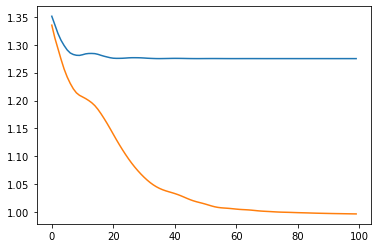

In [ ]:
#| hide
def plot_losses(self: SimpleGPImputationExplorer):
    for l in self.learners:
        plt.plot(l.losses)

plot_losses(gp_imp)

## results

In [ ]:
self = gp_imp
infos = [learner.model.get_info() for learner in self.learners]

In [ ]:
infos

[{'lengthscale':    lengthscale
  0     0.192713,
  'outputscale':    outputscale
  0     0.366132,
  'likelihood':       noise
  0  0.384582},
 {'lengthscale':    lengthscale
  0     1.679326,
  'outputscale':    outputscale
  0     0.910373,
  'likelihood':       noise
  0  0.004235}]

In [ ]:
#| export
@patch
def model_info(self: SimpleGPImputationExplorer):
    "Combine parameters of different kernels into one output" 
    infos = [learner.model.get_info() for learner in self.learners]
    out = {}
    for key in infos[0].keys():
        values = pd.concat([info[key] for info in infos])
        values.insert(0, "variable", self.data.columns)
        out[key] = values 
    return out

In [ ]:
gp_imp.model_info()

{'lengthscale':   variable  lengthscale
 0       x0     0.192713
 0       x1     1.679326,
 'outputscale':   variable  outputscale
 0       x0     0.366132
 0       x1     0.910373,
 'likelihood':   variable     noise
 0       x0  0.384582
 0       x1  0.004235}

In [ ]:
#| export
@patch
def to_result(self: SimpleGPImputationExplorer, data_complete, units=None):
    return GPFAResult(self.predict(), data_complete, self.model_info(), units=units)

In [ ]:
GPFAResult??

Init signature:
GPFAResult(
    data_imputed,
    data_complete,
    model_info,
    units=None,
    metrics_all_data=True,
)
Docstring:      <no docstring>
Source:        
class GPFAResult:
    def __init__(self,
                 data_imputed, #imputed data in tidy format
                 data_complete, # complete data in tidy format
                 model_info, # learner for parameters display
                 units = None, # units for plots
                 metrics_all_data = True # Compute metrics only for gap or for all data?
                ):
        store_attr()
File:           ~/Documents/uni/Thesis/GPFA_imputation/gpfa_imputation/results.py
Type:           type
Subclasses:     


In [ ]:
gp_imp.to_result(fd.data_compl_tidy).display_results()

/home/simone/.local/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

variable,r2
x0,0.2123
x1,0.7596
variable,rmse
x0,0.2954
x1,0.1396


variable,lengthscale
x0,0.1927
x1,1.6793
variable,outputscale
x0,0.3661
x1,0.9104
variable,noise
x0,0.3846
x1,0.0042


In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()